<a href="https://colab.research.google.com/github/Sciederrick/Data-Science-For-EveryOne/blob/main/TelcoCustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [276]:
# Google drive file id for the data set
file_id="1s_6EKj_e3NTRBx45TvPfzWPwr0DO_LZE"

In [277]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

In [278]:
# Suppress all warnings
warnings.filterwarnings("ignore")

url = 'https://drive.google.com/uc?id={}'.format(file_id)
df = pd.read_csv(url)

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# Has your data been loaded correctly (Does the number of rows and columns match your expectation?)
df.shape

(7043, 21)

---------------------------------
*Conduct Data Quality Checks*
---------------------------------

In [279]:
# Assess data through static analysis
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.9,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,57.0,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.9,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes


In [280]:
# Assess data columns for Validity (right format/dtype), Completeness (non-null)
df.info()
# Why is total charges of type object (expect type float64)??

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [281]:
	# Check for missing values (NAN, None) alternative `df.isnull()`
	df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
                   ..
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Length: 21, dtype: int64

In [282]:
	# Check for duplicates
	df.duplicated().sum()

0

In [283]:
	# Understand distribution of your data, outliers, magnitude of numeric data based on statistical summary
  # Action: deal with outliers, determine if you need to scale your data (e.g.,one feature has a mean in the thousands while another has a mean in the single digits)
	df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.0,7043.0,7043.0
mean,0.2,32.4,64.8
std,0.4,24.6,30.1
min,0.0,0.0,18.2
25%,0.0,9.0,35.5
50%,0.0,29.0,70.3
75%,0.0,55.0,89.8
max,1.0,72.0,118.8


-------------------------------------------------------------
*Data Cleaning*
-------------------------------------------------------------
* `df['TotalCharges']` has the wrong type `object`, convert to expected type
`float`
* Inconsistent casing on `tenure`, `gender`, `customerID` (Use PascalCase) to keep things consistent

In [284]:
df.rename(columns={'tenure': 'Tenure', 'gender':'Gender', 'customerID': 'CustomerID'}, inplace=True)

In [285]:
df['TotalCharges'].apply(lambda x: x.strip() == '').value_counts()

False    7032
True       11
Name: TotalCharges, dtype: int64

In [286]:
# Check the category of examples affected by empty strings
df['Churn'][df['TotalCharges'] == ' ']


488     No
753     No
936     No
1082    No
1340    No
        ..
3826    No
4380    No
5218    No
6670    No
6754    No
Name: Churn, Length: 11, dtype: object

In [287]:

# Negative examples are sufficient (too many infact!),
# we can just get rid of the rows with empty strings without replacement
# Exclude rows with TotalCharges culomns contains white space
df = df.loc[~df['TotalCharges'].str.contains(' ')]


In [288]:
# transform TotalCharge col to float
df.loc[:,'TotalCharges'] = df['TotalCharges'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7032 non-null   object 
 1   Gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   Tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [289]:
# Check for accuracy (posible values in categorical data) for each column manually
df["PaperlessBilling"].value_counts()
# df["Churn"].value_counts()

Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64

In [290]:
# Check for class imbalance
class_counts = df["Churn"].value_counts()
print(class_counts)
print(class_counts / len(df) * 100)

No     5163
Yes    1869
Name: Churn, dtype: int64
No    73.4
Yes   26.6
Name: Churn, dtype: float64


---------------------------------------
*Feature Engineering*
---------------------------------------
  - Feature encoding (convert feature values into a format the model can understand)
  - Find feature(s) whose raw values correlate with the label (1.0 for perfect positive correlation, -1.0 for perfect negative correlation, 0 for no correlation)

In [291]:
# Drop customerID, its not used
df.drop(columns=['CustomerID'], inplace=True)

# Define a mapping for each categorical column
label_mappings = {}

# Loop through each categorical column and perform label encoding
for column in df.select_dtypes(include=['object']).columns:
  unique_labels = df[column].unique()
  label_mapping = {label: index for index, label in enumerate(unique_labels)}
  df[column] = df[column].map(label_mapping)
  label_mappings[column] = label_mapping
print(df)

      Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
0          0              0        0           0       1             0   
1          1              0        1           0      34             1   
2          1              0        1           0       2             1   
3          1              0        1           0      45             0   
4          0              0        1           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        0           1      24             1   
7039       0              0        0           1      72             1   
7040       0              0        0           1      11             0   
7041       1              1        0           0       4             1   
7042       1              0        1           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 0                0     

In [292]:
# Make it easier to train the model by maintaining a uniform scale across all features
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
df_mean = df['Tenure'].mean()
df_std = df['Tenure'].std()
df['Tenure'] = (df['Tenure'] - df_mean)/df_std

df_mean = df['MonthlyCharges'].mean()
df_std = df['MonthlyCharges'].std()
df['MonthlyCharges'] = (df['MonthlyCharges'] - df_mean)/df_std

df_mean = df['TotalCharges'].mean()
df_std = df['TotalCharges'].std()
df['TotalCharges'] = (df['TotalCharges'] - df_mean)/df_std

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,-1.3,0,0,0,0,0,0,0,0,0,0,0,0,-1.2,-1.0,0
1,1,0,1,0,0.1,1,1,0,1,1,1,0,0,0,1,1,1,-0.3,-0.2,0
2,1,0,1,0,-1.2,1,1,0,1,0,0,0,0,0,0,0,1,-0.4,-1.0,1
3,1,0,1,0,0.5,0,0,0,1,1,1,1,0,0,1,1,2,-0.7,-0.2,0
4,0,0,1,0,-1.2,1,1,1,0,1,0,0,0,0,0,0,0,0.2,-0.9,1


In [293]:
# The last run did not have `TotalCharges`
df.describe()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0,7032.0
mean,0.5,0.2,0.5,0.3,-0.0,0.9,1.3,0.9,0.7,0.9,0.8,0.7,0.8,0.8,0.7,0.4,1.3,0.0,-0.0,0.3
std,0.5,0.4,0.5,0.5,1.0,0.3,0.6,0.7,0.8,0.7,0.8,0.8,0.8,0.8,0.8,0.5,1.1,1.0,1.0,0.4
min,0.0,0.0,0.0,0.0,-1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.5,-1.0,0.0
25%,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.8,0.0
50%,1.0,0.0,1.0,0.0,-0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.2,-0.4,0.0
75%,1.0,0.0,1.0,1.0,0.9,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.8,0.7,1.0
max,1.0,1.0,1.0,1.0,1.6,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,1.8,2.8,1.0


In [294]:
df.corr()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
Gender,1.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
SeniorCitizen,-0.0,1.0,-0.0,-0.2,0.0,0.0,0.1,-0.0,-0.2,-0.1,-0.2,-0.2,-0.1,-0.1,-0.1,-0.2,-0.1,0.2,0.1,0.2
Partner,0.0,-0.0,1.0,-0.5,-0.4,-0.0,-0.1,-0.0,-0.1,0.1,-0.1,-0.1,-0.1,-0.1,-0.3,-0.0,-0.1,-0.1,-0.3,0.1
Dependents,0.0,-0.2,-0.5,1.0,0.2,-0.0,-0.0,0.0,0.2,0.1,0.2,0.2,0.1,0.1,0.2,0.1,0.1,-0.1,0.1,-0.2
Tenure,0.0,0.0,-0.4,0.2,1.0,0.0,0.3,-0.0,0.1,-0.3,0.2,0.1,0.1,0.1,0.7,-0.0,0.3,0.2,0.8,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaperlessBilling,0.0,-0.2,-0.0,0.1,-0.0,-0.0,-0.1,0.1,0.3,0.3,0.3,0.3,0.2,0.2,0.2,1.0,0.1,-0.4,-0.2,-0.2
PaymentMethod,-0.0,-0.1,-0.1,0.1,0.3,-0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.1,0.1,0.4,0.1,1.0,-0.1,0.2,-0.3
MonthlyCharges,-0.0,0.2,-0.1,-0.1,0.2,0.2,0.5,-0.3,-0.6,-0.7,-0.5,-0.6,-0.4,-0.4,-0.1,-0.4,-0.1,1.0,0.7,0.2
TotalCharges,0.0,0.1,-0.3,0.1,0.8,0.1,0.4,-0.2,-0.2,-0.5,-0.1,-0.1,-0.1,-0.1,0.5,-0.2,0.2,0.7,1.0,-0.2


In [295]:
#@title Feature Selection
# @markdown ---------------------------------------------------------------------
# @markdown  *Feature Selection*
# @markdown  ---------------------------------------------------------------------
# @markdown  *Columns with low correlation with the label (low predictive power).*
# @markdown  * `Gender`
# @markdown  * `PhoneService`
# @markdown  * `MultipleLines`
# @markdown  * `InternetService`
# @markdown
# @markdown  Exclude these.
# @markdown Features used to train the model on e.g.,
# @markdown ```Python
# @markdown inputs = {
# @markdown   'MonthlyCharges': tf.keras.Input(shape=(1,)),
# @markdown }
# @markdown ```


columns_to_ignore = ['Churn', 'Gender', 'PhoneService', 'MultipleLines', 'InternetService']
inputs = {}
for column in df.columns:
  if column not in columns_to_ignore:
    inputs[column] = tf.keras.Input(shape=(1,))


----------------------------------------------------------------
*Create & Train Model*
----------------------------------------------------------------

In [296]:
#@title Define the functions that create and train a model.
def create_model(my_inputs, my_learning_rate, METRICS):
  # Use a Concatenate layer to concatenate the input layers into a single tensor.
  # as input for the Dense layer. Ex: [input_1[0][0], input_2[0][0]]
  concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
  dense = layers.Dense(units=1, name='dense_layer', activation=tf.sigmoid)
  dense_output = dense(concatenated_inputs)
  """Create and compile a simple classification model."""
  my_outputs = {
    'dense': dense_output,
  }
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
  return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  print(dataset)
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [297]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [299]:
#@title Split Data into Traning & Test Sets

df = df.reindex(np.random.permutation(df.index)) # shuffle the training set

X = df.drop('Churn', axis=1)  # Adjust 'target_column' to your target variable
y = df['Churn']

# Split the data into train and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = pd.DataFrame(y_train, columns=['Churn'])
y_test = pd.DataFrame(y_test, columns=['Churn'])

# Concatenate X_train and y_train_df along columns (axis=1)
train_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)
# Create TensorFlow datasets from the splits
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
train_dataset.head()


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6175,1,0,0,1,-0.0,1,1,1,1,0,0,0,0,1,1,0,0,0.9,0.3,0
2717,0,0,0,1,1.6,1,2,0,1,0,1,1,1,1,2,1,2,0.9,2.0,0
1978,0,0,1,0,1.0,1,1,0,0,0,1,1,1,0,2,1,1,0.2,0.7,0
2943,1,0,1,0,0.3,1,2,2,2,2,2,2,2,2,2,0,1,-1.3,-0.6,0
3912,0,0,0,1,1.1,1,2,1,1,0,1,1,1,1,2,1,3,1.7,2.0,0


      Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
6175       1              0        0           1    -0.0             1   
2717       0              0        0           1     1.6             1   
1978       0              0        1           0     1.0             1   
2943       1              0        1           0     0.3             1   
3912       0              0        0           1     1.1             1   
...      ...            ...      ...         ...     ...           ...   
3115       0              0        1           0    -0.8             1   
6989       0              0        0           1    -0.5             1   
6024       0              0        0           0    -1.2             1   
3774       1              1        0           1     0.8             1   
4382       0              1        1           0    -1.2             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
6175              1                1     

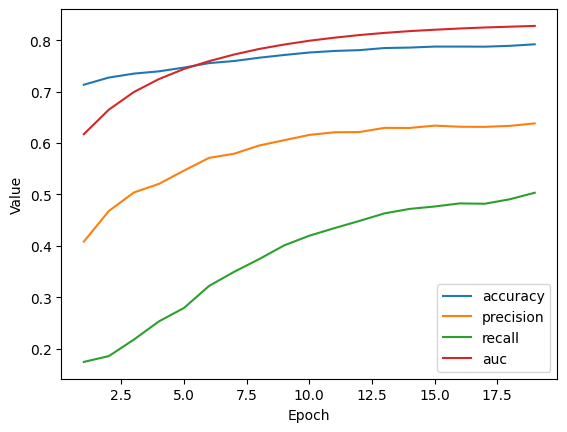

In [300]:
#@title Invoke Model Creation, Plot Training Performance
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "Churn"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
      tf.keras.metrics.AUC(num_thresholds=100, name="auc")
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_dataset, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", "auc"]
plot_curve(epochs, hist, list_of_metrics_to_plot)

---------------------------------------------------------------------
*Evaluate Model Using Test Set*
---------------------------------------------------------------------

In [301]:
features = {name:np.array(value) for name, value in test_dataset.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

15/15 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.7768 - precision: 0.6034 - recall: 0.4747 - auc: 0.8272


[0.43613630533218384,
 0.7768301367759705,
 0.6033898591995239,
 0.47466665506362915,
 0.8272093534469604]